In [3]:
import torch

In [1]:
# ! ls /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/cell-detection/

1_evaluate_results.ipynb
2_scatters.ipynb
accuracy.txt
adapt_for_cell_graph_models.py
aggregate_cross_validation_data.py
annotate_visium_cells.py
CellDatasetAnnotation.rmd
Cell_Dataset_Preprocessing.ipynb
Cell_Detection.ipynb
celldetection_nms.py
celldetection.py
cell-detections
cell_model_from_repr_g4_regressor_cytassist_e1_unifiedSingleCell_pathways_violin.png
cell_model.py
cell_model_with_pathways_genes_to_use.ptsave
cell_regularizer.py
Colocalization.ipynb
create_aligned_umap.py
create_graph.py
cytassist_aeh.py
cytassist_segmentation.py
cytassist_spatialde.py
data
datasets.py
dataset_wrapper.py
detectron2
enqueue_training.py
failed.log
failsafe.sh
figures
filtered_set_accessible_by_all_datasets.npy
filtered_set.npy
gene_sets.py
Gene_Sets.txt
image_0.png
image.png
infer_held_out_genes.ipynb
infer.py
input_data
interactive_cpu.sh
interactive_pyg_cpu.sh
interactive_pyg.sh
interactive.sh
Interpretability.ipynb
job.slurm
job_train.sh
job_validate.sh
LizardModelEval.ipynb
lizard_models
l

In [4]:
results={"none":dict(),"repr":dict()}

for k in results:
    val_dir="v0"
    if k=="repr":
        val_dir+="_repr"
    for k2 in ['none','cellreg']:
        results[k][k2]=torch.load(f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/cell-detection/training_results_v2/{val_dir}/cellmodel_prior-{k}_{'cellreg-enabled_' if k2=='cellreg' else ''}heldout-autostainer_validation_results.pt",map_location="cpu")



In [ ]:
# ! pip uninstall -y omicsio && pip install git+https://github.com/jlevy44/omicsio --no-deps

In [7]:
from load_datasets import load_patient


with open("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/cell-detection/training_results_v2/v0/genes.txt") as f:
    valid_dataset = load_patient("autostainer", f.read().splitlines())



NameError: name 'prediction_indices' is not defined

In [9]:
log_counts = torch.stack([valid_dataset[i][1] for i in results[k][k2]['prediction_indices']]).cpu().numpy()

In [1]:
# ! pip install cached-property

In [48]:
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score
for k in results:
    for k2 in ['none','cellreg']:
        y_pred=torch.vstack(results[k][k2]['predictions']['graph_vector_batch'])#['stats'].keys()
        true_pred=np.stack([pd.DataFrame(log_counts).apply(lambda x: x>np.quantile(x,0.5), axis=0).values,y_pred])
        aucs= [(roc_auc_score(true_pred[0,:,i],true_pred[1,:,i]) if true_pred[0,:,i].sum() else np.nan) for i in range(true_pred.shape[-1])]
        print(np.nanmedian(aucs))

0.8404681309828785
0.8401743518491376
0.8459309953697826
0.8363202237154068


(array([  4.,  22.,  46., 110.,  88.,  63.,  59., 119., 271., 213.]),
 array([0.35498454, 0.41604937, 0.4771142 , 0.53817904, 0.59924387,
        0.6603087 , 0.72137353, 0.78243836, 0.84350319, 0.90456803,
        0.96563286]),
 <BarContainer object of 10 artists>)

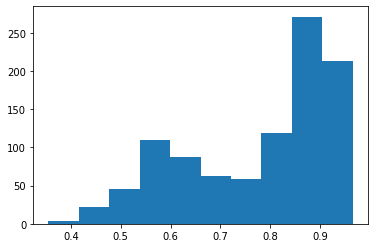

In [50]:
import matplotlib.pyplot as plt
plt.hist(aucs)

In [37]:
(pd.DataFrame(log_counts).apply(lambda x: x>np.quantile(x,0.7), axis=0).sum()==0).sum()

5

0.8363202237154068

In [ ]:
pd.Panel(true_pred).to_xarray()

In [ ]:
import numpy as np
for k in results:
    for k2 in ['none','cellreg']:
        print(k,k2,np.nanmedian(results[k][k2]['stats']['pearsonr_values']))

In [16]:
res['predictions'].keys()

dict_keys(['graph_vector_batch', 'cell_vectors_batch'])

In [20]:
len(res['stats']['mse_values'])

1000

In [22]:
! cat /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/autostainer_study/validation.py

import os
import traceback
from functools import cached_property

import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
import torch
import torch.nn.functional as F

import loss


def spearman(pred: np.ndarray, true: np.ndarray):
    return np.array([
        scipy.stats.spearmanr(pred[:, i], true[:, i])
        for i in range(pred.shape[1])
    ])

def rmse(pred: np.ndarray, true: np.ndarray):
    return np.sqrt(((pred - true) ** 2).mean(axis=0))


class Validation:
    def __init__(self, true: torch.Tensor, pred: torch.Tensor):
        self.true = true.cpu()
        self.pred = pred.cpu()

    def __getstate__(self):
        return {
            'true': self.true.cpu(),
            'pred': self.pred.cpu()
        }

    def __setstate__(self, state):
        self.true = state['true'].cpu()
        self.pred = state['pred'].cpu()

    @cached_property
    def spearman(self):
        pred_np = self.pred.cpu().numpy()
        true_np = self.true.cpu().numpy(

In [192]:
from aggregate_cross_validation_data import aggregate_cross_val_data
import pandas as pd

genes = open("training_results_v2/v2_repr_contrastive/genes.txt").read().split("\n")

res=dict()
for k,v in list(dict(v7_cell_models_augmented_2_epochs="cellmodel_prior-none_cellreg-enabled_heldout",
    v6_cnn_models_augmented_2_epochs="inception-holding-out",
    v2_repr_contrastive="cellmodel_prior-repr_cellreg-enabled_heldout",
    v0_repr="cellmodel_prior-repr_cellreg-enabled_heldout").items())+[("v2_repr_contrastive","cellmodel_prior-none_heldout")]:
    
    res_=dict(zip(['auc','spearman','mse'],aggregate_cross_val_data(
        f"./training_results_v2/{k}/{v}"+"-{patient}"
    )))['auc']
    res[f"{k.split('_')[0]}-{v.replace('-enabled','').replace('_heldout','').replace('-holding-out','')}"]=pd.Series(res_,index=genes)


# # cell results
# cell_aurocs, cell_spearmans, cell_mses = aggregate_cross_val_data(
#     "./training_results_v2/v7_cell_models_augmented_2_epochs/cellmodel_prior-none_cellreg-enabled_heldout-{patient}"
# )

# # cnn results
# cnn_aurocs, cnn_spearmans, cnn_mses = aggregate_cross_val_data(
#     "./training_results_v2/v6_cnn_models_augmented_2_epochs/inception-holding-out-{patient}"
# )



Skipping ./training_results_v2/v2_repr_contrastive/cellmodel_prior-none_heldout-092842_16 due to [Errno 2] No such file or directory: './training_results_v2/v2_repr_contrastive/cellmodel_prior-none_heldout-092842_16_stats.json'


In [193]:
res_df=pd.DataFrame(res)

In [194]:
res_df

,v7-cellmodel_prior-none_cellreg,v6-inception,v2-cellmodel_prior-repr_cellreg,v0-cellmodel_prior-repr_cellreg,v2-cellmodel_prior-none
A2M,0.667235,0.672462,0.587646,0.603700,0.645706
ABCC3,0.861416,0.875039,0.851535,0.846627,0.865732
ABHD11,0.860140,0.868726,0.847097,0.846644,0.855847
ABHD17C,0.869146,0.880951,0.859642,0.859470,0.875261
ABI3BP,0.637506,0.646545,0.600331,0.615985,0.614193
...,...,...,...,...,...
ZFP36,0.632228,0.669125,0.633470,0.634254,0.670223
ZFP36L1,0.736027,0.763410,0.712361,0.714205,0.746408
ZG16,0.606872,0.633435,0.599478,0.606013,0.595914
ZG16B,0.814487,0.834515,0.821485,0.810558,0.828027


In [195]:
import gseapy.enrichr
import numpy as np
import tqdm
i=0
enrichr_res_dict=dict()
# enrichr_res_list=[gseapy.enrichr(gene_list=res_df.sort_values(res_df.columns[i],ascending=False).index.tolist()[:x], cutoff=1., gene_sets='MSigDB_Hallmark_2020', outdir='enrichr_results/test').results.query("`Adjusted P-value`>1e-3").iloc[0,4] for x in tqdm.tqdm(np.arange(20,250,20))]
def try_except(fn,**args):
    try: 
        return fn(**args)
    except:
        return try_except(fn,**args)
for i in range(len(res_df.columns)):
    enrichr_res_list=[(try_except(gseapy.enrichr,**dict(gene_list=res_df.sort_values(res_df.columns[i],ascending=False).index.tolist()[:x], cutoff=1., gene_sets='MSigDB_Hallmark_2020', outdir='enrichr_results/test')).results.iloc[:,4]>0.01).mean() for x in tqdm.tqdm(np.arange(20,250,20))]
    enrichr_res=gseapy.enrichr(gene_list=res_df.sort_values(res_df.columns[i],ascending=False).index.tolist()[:np.arange(20,250,20)[np.argmin(enrichr_res_list)]], cutoff=1.,  gene_sets='MSigDB_Hallmark_2020', outdir='enrichr_results/test')
    enrichr_res_dict[res_df.columns[i]]=enrichr_res.results


# ! mkdir enrichr_results
# gseapy.enrichr(gene_list=gl, gene_sets='KEGG_2016', outdir='test')

100%|████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.02s/it]


In [196]:
# ! rm enrichr_prelim_results.xlsx

In [197]:
with pd.ExcelWriter('enrichr_prelim_results.xlsx') as writer:  
    for k in enrichr_res_dict:
        enrichr_res_dict[k].to_excel(writer, sheet_name=k)

In [181]:
! realpath enrichr_prelim_results.xlsx

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/cell-detection/enrichr_prelim_results.xlsx


In [179]:
enrichr_res_dict

{'v7_cell_models_augmented_2_epochs-cellmodel_prior-none_cellreg-enabled_heldout':                 Gene_set                     Term Overlap   P-value  \
 0   MSigDB_Hallmark_2020          Apical Junction   3/200  0.000991   
 1   MSigDB_Hallmark_2020  Estrogen Response Early   3/200  0.000991   
 2   MSigDB_Hallmark_2020        Androgen Response   2/100  0.004434   
 3   MSigDB_Hallmark_2020    Xenobiotic Metabolism   2/200  0.016795   
 4   MSigDB_Hallmark_2020        Protein Secretion    1/96  0.091787   
 5   MSigDB_Hallmark_2020           UV Response Up   1/158  0.146750   
 6   MSigDB_Hallmark_2020               Myogenesis   1/200  0.182171   
 7   MSigDB_Hallmark_2020        KRAS Signaling Up   1/200  0.182171   
 8   MSigDB_Hallmark_2020                  Hypoxia   1/200  0.182171   
 9   MSigDB_Hallmark_2020               Glycolysis   1/200  0.182171   
 10  MSigDB_Hallmark_2020      Allograft Rejection   1/200  0.182171   
 
     Adjusted P-value  Old P-value  Old Adjusted P-v

In [175]:
import numpy as np
import tqdm
i=4
# enrichr_res_list=[gseapy.enrichr(gene_list=res_df.sort_values(res_df.columns[i],ascending=False).index.tolist()[:x], cutoff=1., background=res_df.index, gene_sets='MSigDB_Hallmark_2020', outdir='enrichr_results/test').results.iloc[0,3] for x in tqdm.tqdm(np.arange(20,250,20))]
# enrichr_res=gseapy.enrichr(gene_list=res_df.sort_values(res_df.columns[i],ascending=False).index.tolist()[:np.arange(20,250,20)[np.argmin(enrichr_res_list)]], cutoff=1., background=res_df.index, gene_sets='MSigDB_Hallmark_2020', outdir='enrichr_results/test')




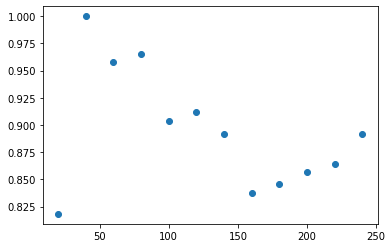

In [176]:
import matplotlib, matplotlib.pyplot as plt
plt.scatter(np.arange(20,250,20),enrichr_res_list)

In [177]:
enrichr_res.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Apical Junction,3/200,0.000991,0.005448,0,0,17.721409,122.583777,CLDN4;JUP;CLDN7
1,MSigDB_Hallmark_2020,Estrogen Response Early,3/200,0.000991,0.005448,0,0,17.721409,122.583777,ELF3;CLDN7;KRT8
2,MSigDB_Hallmark_2020,Androgen Response,2/100,0.004434,0.016260,0,0,22.541950,122.139960,TPD52;KRT8
3,MSigDB_Hallmark_2020,Xenobiotic Metabolism,2/200,0.016795,0.046186,0,0,11.101010,45.366284,JUP;SPINT2
4,MSigDB_Hallmark_2020,Protein Secretion,1/96,0.091787,0.182171,0,0,11.016620,26.310792,TPD52
5,MSigDB_Hallmark_2020,UV Response Up,1/158,0.146750,0.182171,0,0,6.645323,12.752542,EPCAM
6,MSigDB_Hallmark_2020,Myogenesis,1/200,0.182171,0.182171,0,0,5.231685,8.908557,KLF5
7,MSigDB_Hallmark_2020,KRAS Signaling Up,1/200,0.182171,0.182171,0,0,5.231685,8.908557,JUP
8,MSigDB_Hallmark_2020,Hypoxia,1/200,0.182171,0.182171,0,0,5.231685,8.908557,TPD52
9,MSigDB_Hallmark_2020,Glycolysis,1/200,0.182171,0.182171,0,0,5.231685,8.908557,ELF3


In [60]:
# ! pip install  gseapy

In [55]:
pd.DataFrame(res).median(0)

v7_cell_models_augmented_2_epochs-cellmodel_prior-none_cellreg-enabled_heldout    0.808414
v6_cnn_models_augmented_2_epochs-inception-holding-out                            0.820396
v2_repr_contrastive-cellmodel_prior-repr_cellreg-enabled_heldout                  0.804855
v0_repr-cellmodel_prior-repr_cellreg-enabled_heldout                              0.799276
v2_repr_contrastive-cellmodel_prior-none_heldout                                  0.809251
dtype: float64

In [13]:
# cell_aurocs

In [52]:
# ! ls training_results_v2/v2_repr_contrastive
# ! ls training_results_v2/v0_repr
# ! ls training_results_v2/v0_repr
# ! ls training_results_v2/v7_cell_models_augmented_2_epochs
# ! ls training_results_v2/

v0		       v5_cnn_models
v0_repr		       v6_cnn_models_augmented_2_epochs
v1_repr_contrastive    v7_cell_models_augmented_2_epochs
v2_repr_contrastive    v8_mini_graph_laplacian
v3_singlecell_sumpool  v9_mini_graph_laplacian_cnn_comparison
v4_optimal_transport


In [17]:
! ls training_results_v2/v1_repr_contrastive

representation_history.pt  representation_model.pt
